In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

import sklearn
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from scipy.stats import randint
import warnings
warnings.filterwarnings('ignore')

`gdp_ca` : The GDP of each county in CA for 2019 <br>
`pop` : The population of each county in CA for 2019

In [2]:
#Filters to get 2019 CA GDP for each county
gdp = pd.read_csv('data/lagdp1220.csv', thousands=',')
gdp =gdp.loc[:,['State','2019']]
ca_ind= gdp[gdp['State'] == 'California'].index
gdp_ca = gdp.iloc[194:194+59,:]
gdp_ca =gdp_ca.rename(columns= {'State':'CA', '2019':'2019 GDP'}).iloc[1:,:].reset_index(drop= True)

#Adds the population of each county from 2019
pop = pd.read_csv('data/CA_pop_2019.csv').sort_values('County',ascending= True).reset_index()
gdp_ca['pop'] = pop['Population']
gdp_ca

,CA,2019 GDP,pop
0,Alameda,129708807.0,1671329
1,Alpine,114254.0,1129
2,Amador,1786635.0,39752
3,Butte,9897121.0,219186
4,Calaveras,1589059.0,45905
5,Colusa,1514361.0,21547
6,Contra Costa,76522619.0,1153526
7,Del Norte,842938.0,27812
8,El Dorado,7967457.0,192843
9,Fresno,46009312.0,999101


`cars_county` : Vehicle Population for each County in CA for various fuel types that are defined below ZEV and Non ZEV (NZEV) for 2019 <br>

**Zero- Emission Vehicles(ZEV):**

1. BEV = Battery Electric <br>
1. PHEV = Plug-in Hybrid<br>
1. FCEV = Fuel Cell<br>

**NZEV:**
1. Bio Diesel
1. Diesel
1. Flex Fuel
1. Gasoline
1. Gasoline Hybrid
1. Natural Gas

`vehicles`: Dataframe <br>
   * `NZEV Vehicles`: The number of NZEV in a registered in a county <br>
   * `prop ZEV`: The proprtion of ZEV registered in a county


In [3]:
cars = pd.read_csv('data/Vehicle Population_Last updated 08-28-2020.csv')
cars = cars[cars['Data Year'] == 2019].drop(columns = ['Data Year'])
cars_county = cars.groupby(['County', 'Fuel Type']).sum().reset_index()

In [4]:
#combined to Get Total ZEV vehicles

EV = cars_county['Fuel Type'].str.contains('EV')
ZEV = cars_county[EV].groupby('County').sum().rename(columns={'Number of Vehicles':'ZEV Vehicles'})

#Get total None ZEV
gas = cars_county['Fuel Type'].str.contains('Gas')
diesel = cars_county['Fuel Type'].str.contains('Diesel')
fuel = cars_county['Fuel Type'].str.contains('Fuel')
NZEV_ind = gas | diesel| fuel
NZEV = cars_county[NZEV_ind].groupby('County').sum().rename(columns={'Number of Vehicles':'NZEV Vehicles'})

#Calc Proprotion Vehicles in the County that are ZEV
total_cars = NZEV['NZEV Vehicles'] + ZEV['ZEV Vehicles']
NZEV['prop ZEV'] = ZEV['ZEV Vehicles']/total_cars
vehicles = NZEV
vehicles.head()

,NZEV Vehicles,prop ZEV
County,,
Alameda,1110406,0.037187
Alpine,1553,0.003849
Amador,39128,0.004453
Butte,154129,0.005138
Calaveras,50711,0.004398


`emission_sites`: comprised of the `aggregated_vista_ca_by_county_emseic_merged`, but exluding emission sites that are not related to gas or industrial processes (later found better to not use any of the counts for different Methane Emitting Sources, so will only keep `Closest_County_Centroid`, `ALAND`, `PM`, `PM2_5`, `PM10`)

In [5]:
#Next Dataset  Vist_CA and Emseic 
emission_sites = pd.read_csv('data/aggregated_vista_ca_by_county_emseic_merged.csv')
cols = [ 'Closest_County_Centroid','Compressed Natural Gas Fueling Station', 'Liquefied Natural Gas Fueling Station',
       'Natural Gas Processing Plants', 'Natural Gas Station',
       'Natural Gas Storage Field', 'Oil and Gas Facility Boundary',
       'Oil and Gas Field Boundary', 'Oil and Gas Well', 'Power Plant',
       'Refinery', 'Wastewater Treatment Plant', 'ALAND','TOG', 'ROG', 'NOX', 'COT',
       'SOX', 'PM', 'PM10', 'PM2_5']
emission_sites = emission_sites.loc[:,cols]
emission_sites.head()

,Closest_County_Centroid,Compressed Natural Gas Fueling Station,Liquefied Natural Gas Fueling Station,Natural Gas Processing Plants,Natural Gas Station,Natural Gas Storage Field,Oil and Gas Facility Boundary,Oil and Gas Field Boundary,Oil and Gas Well,Power Plant,...,Wastewater Treatment Plant,ALAND,TOG,ROG,NOX,COT,SOX,PM,PM10,PM2_5
0,ALAMEDA,0,3,0,35,0,8,0,105,24,...,8,1914242789,134.840060,52.964215,70.393760,218.327664,2.1303,29.412402,18.091634,8.204909
1,AMADOR,0,0,0,1,0,0,0,1,1,...,0,1539933576,10.252184,5.091711,4.357744,19.055692,0.1249,8.725638,5.396293,2.941648
2,BUTTE,0,0,0,9,0,0,0,237,4,...,1,4238423343,23.291007,14.396062,18.730721,69.518978,0.2657,31.816585,17.991954,5.661389
3,CALAVERAS,0,0,0,2,0,0,0,1,2,...,1,2641820834,11.288079,5.075024,2.769050,21.024100,0.0387,5.729100,3.691200,1.326400
4,COLUSA,0,0,0,13,1,9,0,873,2,...,0,2980372757,14.777140,6.412037,11.158445,20.365611,0.3754,25.530000,12.832200,2.935700


In [6]:
#merge three tables on columns that represents the County

one = gdp_ca.merge(vehicles, left_on= 'CA', right_on= 'County')
one['County'] = one['CA'].str.upper().drop(columns = ['CA'])
one.drop(columns = ['CA'], inplace= True)
CA = emission_sites.merge(one, left_on= 'Closest_County_Centroid', right_on= 'County').drop(columns = ['Closest_County_Centroid'])
CA =CA.set_index('County')
CA

,Compressed Natural Gas Fueling Station,Liquefied Natural Gas Fueling Station,Natural Gas Processing Plants,Natural Gas Station,Natural Gas Storage Field,Oil and Gas Facility Boundary,Oil and Gas Field Boundary,Oil and Gas Well,Power Plant,Refinery,...,NOX,COT,SOX,PM,PM10,PM2_5,2019 GDP,pop,NZEV Vehicles,prop ZEV
County,,,,,,,,,,,,,,,,,,,,,
ALAMEDA,0,3,0,35,0,8,0,105,24,0,...,70.393760,218.327664,2.130300,29.412402,18.091634,8.204909,129708807.0,1671329,1110406,0.037187
AMADOR,0,0,0,1,0,0,0,1,1,0,...,4.357744,19.055692,0.124900,8.725638,5.396293,2.941648,1786635.0,39752,39128,0.004453
BUTTE,0,0,0,9,0,0,0,237,4,0,...,18.730721,69.518978,0.265700,31.816585,17.991954,5.661389,9897121.0,219186,154129,0.005138
CALAVERAS,0,0,0,2,0,0,0,1,2,0,...,2.769050,21.024100,0.038700,5.729100,3.691200,1.326400,1589059.0,45905,50711,0.004398
COLUSA,0,0,0,13,1,9,0,873,2,0,...,11.158445,20.365611,0.375400,25.530000,12.832200,2.935700,1514361.0,21547,18797,0.001487
CONTRA COSTA,4,0,0,78,1,1,0,708,22,4,...,52.645895,154.686729,16.714600,25.244861,16.876147,9.729282,76522619.0,1153526,857703,0.026135
DEL NORTE,0,0,0,0,0,0,0,2,0,0,...,5.338307,10.662717,0.533500,6.911035,4.268890,1.091645,842938.0,27812,18999,0.003984
EL DORADO,0,0,0,0,0,0,0,0,0,0,...,7.714936,48.943018,0.151300,15.922605,9.695370,2.759783,7967457.0,192843,163932,0.014376
FRESNO,1,1,1,15,1,42,0,780,8,0,...,82.024090,156.288386,1.458423,123.790497,64.417049,15.442359,46009312.0,999101,657262,0.007572


Use StandardScaler to standardize each feature before running the regression because regularization methods like Ridge and Lasso regression penalize the size of the coefficients. Normalizing the variables reflects the features that are actually important predictor , so the regegularization will shrinking features that have less predictive power instead of falsey keeping features with the largest ranges as important predictors when they might not be.

In [7]:
from sklearn.preprocessing import StandardScaler

def get_X_y_stnd(df, y_col, test_prop, rand_seed, drop_cols = []):
    """
    This function returns four dataframes containing the testing and training X and y values used in land-use regression.
    It standardizes the X variables prior to splitting the data.
    Input: df, a Pandas dataframe with all of the fields in the land-use regression dataset; 
        cols_to_drop, a list of the names (strings) of the columns to drop from df in order to obtain the feature variables.
        y_col, a column name (as a string) of df that represents the response variable
        test_prop, a float between 0 and 1 indicating the fraction of the data to include in the test split
        rand_seed, an integer, used to define the random state
    Returns: X_train, X_test, y_train, y_test, four dataframes containing the training and testing subsets of the 
    feature matrix X and response matrix y
    """
    
    # YOUR CODE HERE
    X = df.drop(columns= drop_cols)
    y = df[[y_col]]
    
    scaler = StandardScaler()
    scaler.fit(X)
    x_trans = scaler.transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(x_trans, y ,test_size = test_prop, random_state = rand_seed)
    
    return X_train, X_test, y_train, y_test

X_drop_col = ['COT', 'NOX', 'SOX','TOG', 'ROG','Compressed Natural Gas Fueling Station',
       'Liquefied Natural Gas Fueling Station',
       'Natural Gas Processing Plants', 'Natural Gas Station',
       'Natural Gas Storage Field', 'Oil and Gas Facility Boundary',
       'Oil and Gas Field Boundary', 'Oil and Gas Well',
       'Refinery', 'Wastewater Treatment Plant', 'Power Plant']
X_train, X_test, y_train, y_test = get_X_y_stnd(CA, 'COT', .25, 2020,X_drop_col)
X = CA.drop(columns = X_drop_col)

In [8]:
def model_cv_mse(Model, X, y, alphas, k = 3):
    """
    This function calculates the MSE resulting from k-fold CV using Lasso or Ridge regression performed on a training subset of 
    X and y for different values of alpha.
    Inputs: 
        Model (sklearn model): the type of sklearn model with which to fit the data - LinearRegression, Ridge, or Lasso
        X: the set of features used to fit the model
        y: the set of response variable observations
        alphas: a list of penalty parameters
        k: number of folds in k-fold cross-validation
    Returns:
        mses: a list containing the mean squared cross-validation error corresponding to each value of alpha
    """
    mses = np.full((k, len(alphas)), np.nan) # initialize array of MSEs to contain MSE for each fold and each value of alpha
        
    kf = KFold(k, random_state=9,shuffle = True) # get kfold split
    
    #makes y a series, so can index

    
    fold = 0
    for train_i, val_i in kf.split(X):
        # get training and validation values
        X_f_train = X[train_i]
        X_f_val = X[val_i]
        y_f_train = y.iloc[train_i,0]
        y_f_val = y.iloc[val_i,0]
    
        
        for i in range(len(alphas)): # loop through alpha values
            model = Model(alpha = alphas[i]) # initialize model

            model.fit(X_f_train,y_f_train) # fit model
            
            
            y_pred = model.predict(X_f_val) # get predictions
            
            # save MSE for this fold and alpha value
            mses[fold, i] = mean_squared_error(y_f_val, y_pred)
        
        fold += 1
    
    average_mses = np.full((len(alphas), 1), np.nan) # get average MSE for each alpha value across folds
    for i in range(len(alphas)):
        average_mses[i,:] = np.mean(mses[:, i])
    
    return average_mses, model.coef_

In [9]:
def plot_mse(range, model_CV, model_name):
    plt.plot(range, model_CV)
    plt.title('Try to find the Alpha value for '+ model_name +' min MSE')
    plt.xlabel('alpha')
    plt.ylabel('MSE')


In [10]:
lasso_alpha = np.arange(0.0001,1, 0.001)
lasso_cv_both =model_cv_mse(Lasso, X_train, y_train, alphas = lasso_alpha)
lasso_cv = lasso_cv_both[0]

kf = KFold(len(X_train), random_state= 2020, shuffle= True) # get KFold cross-validation selector object
lassocv = LassoCV(cv = kf, alphas= lasso_alpha) # pass CV object and list of alphas to LassoCV()
lassocv.fit(X_train,y_train) # fit RidgeCV model on training data

alpha_opt = lassocv.alpha_ # get optimal alpha value

y_pred_lassocv = lassocv.predict(X_test) # get test predictions using RidgeCV model

lassocv_mse = mean_squared_error(y_test, y_pred_lassocv) # get MSE of LassoCV model

optimal alpha: 0.18409999999999999
Test MSE with cross-validated Lasso: 1622.0100059345943
R^2:  0.9849738955010227


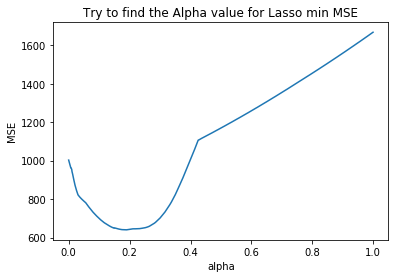

In [11]:
#LASSO
plot_mse(lasso_alpha, lasso_cv, 'Lasso')
print("optimal alpha:", alpha_opt)
print("Test MSE with cross-validated Lasso:", lassocv_mse)
print('R^2: ', r2_score(y_test, y_pred_lassocv))


In [12]:
#Ridge
ridge_alphas = np.arange(0.0001,0.1,.001)
ridge_cv_both = model_cv_mse(Ridge,X_train,y_train,ridge_alphas )
ridge_cv =  ridge_cv_both[0]

kf = KFold(len(X_train), random_state= 2020, shuffle= True) # get KFold cross-validation selector object
ridgecv = RidgeCV(cv = kf, alphas=ridge_alphas) # pass CV object and list of alphas to RidgeCV()
ridgecv.fit(X_train, y_train) # fit RidgeCV model on training data

alpha_opt = ridgecv.alpha_ # get optimal alpha value

y_pred_ridgecv = ridgecv.predict(X_test) # get test predictions using RidgeCV model

ridgecv_mse = mean_squared_error(y_test, y_pred_ridgecv) # get MSE of RidgeCV model


In [13]:
len(y_test)

14

optimal alpha: 0.0001
Test MSE with cross-validated Ridge: 1544.1077247507324
R^2:  0.985695572810962


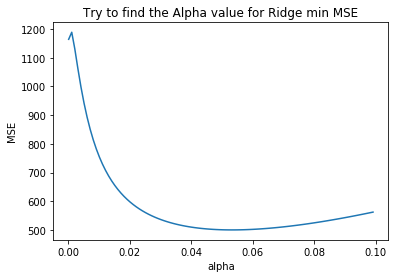

In [14]:
plot_mse(ridge_alphas,ridge_cv, 'Ridge')
print("optimal alpha:", alpha_opt)
print("Test MSE with cross-validated Ridge:", ridgecv_mse)
print('R^2: ', r2_score(y_test, y_pred_ridgecv))

Boosting is an ensemble method where a new tree is chosen to minimzie the residual of an existing aggregation of trees. The number of boosts or the parameter `n_estimators` can be tuned using cross validation. Gradient Boosting Regressor builds an addativ emodel in a forward stage wise-fashion. Each iteration the reression tree is fit on the negative gradient of the given loss function.

In [15]:
#Gradient Bootsting Regressor
#Using the Train and test set from Lasso and Ridge, creating Validation set

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 2020)

gb_tree = GradientBoostingRegressor(random_state=2020)
gb_tree.fit(X_train, y_train)

gb_train_score = gb_tree.score(X_train, y_train)
gb_val_score = gb_tree.score(X_val, y_val)

print('Train Score: ', gb_train_score)
print('Validation Score: ', gb_val_score)
print('Test Score: ', gb_tree.score(X_test, y_test))

Train Score:  0.9999911926952204
Validation Score:  0.8703960164987743
Test Score:  0.32078159852342103


In [16]:
def importance_plot(tree):
    # YOUR CODE HERE
    feature_importance = tree.feature_importances_ # get the importance of each feature
    
    #calculate the relative feature importance and save to a dataframe with two columns: 
    # One holding the names of the features, and one holding the associated relative importance 
    # of each feature.
    relative_importance = (feature_importance/max(feature_importance)) *100
    feat_df = pd.DataFrame({'Feature': X.columns, 'Relative Importance': relative_importance})
    
    # Sort feat_df in order of importance
    feat_df = feat_df.sort_values(by = 'Relative Importance',ascending=True)
    
    plt.figure(figsize=(8, 7.5))
    plt.barh(feat_df['Feature'],feat_df['Relative Importance'])
    plt.xlabel('Relative feature importance');

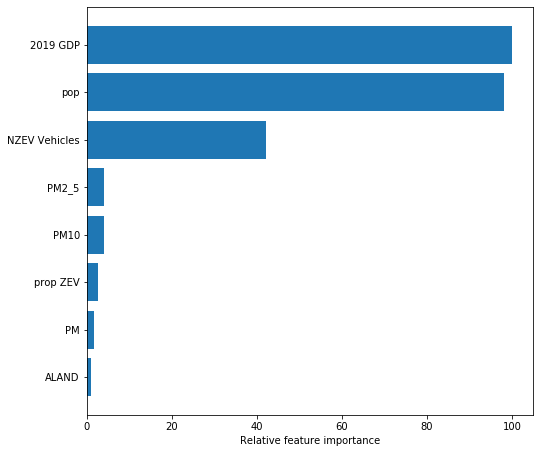

In [17]:
importance_plot(gb_tree)

In [18]:
param_dist = {'n_estimators' : randint(100,200),
             'max_features' : randint(0,X_train.shape[1])} 

rnd_gb_search = RandomizedSearchCV(gb_tree,param_distributions=param_dist, random_state= 2020)

rnd_gb_search.fit(X_train, y_train.values.ravel())

print(rnd_gb_search.best_params_)

{'max_features': 2, 'n_estimators': 109}


In [19]:
gb_tree = GradientBoostingRegressor(n_estimators=109, max_features=2,random_state=2020)
gb_tree.fit(X_train, y_train)

gb_train_score = gb_tree.score(X_train, y_train)
gb_val_score = gb_tree.score(X_val, y_val)

print('Train Score: ', gb_train_score)
print('Validation Score: ', gb_val_score)
print('Test Score: ', gb_tree.score(X_test, y_test))

Train Score:  0.9999974447201122
Validation Score:  0.8673071899279117
Test Score:  0.3467860615786388


**Findings**

optimal alpha: 0.0001
Test MSE with cross-validated Lasso: 1622.0100059345943
R^2:  0.9849738955010227


Text(0.5, 1.0, 'See which Features are the best predictors!')

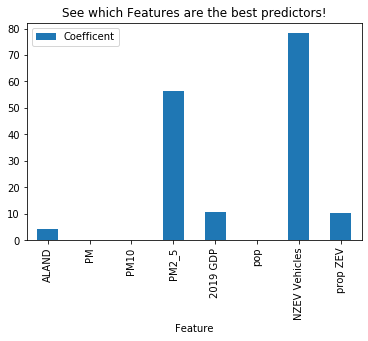

In [20]:
#LASSO
print("optimal alpha:", alpha_opt)
print("Test MSE with cross-validated Lasso:", lassocv_mse)
print('R^2: ', r2_score(y_test, y_pred_lassocv))

col_coef_zipped = zip(X.columns, lasso_cv_both[1])
col_coef = dict(col_coef_zipped)
feature_coef =pd.DataFrame(col_coef.items()).rename(columns ={0:'Feature', 1: 'Coefficent'})
feature_coef['Coefficent'] = np.abs(feature_coef['Coefficent'])

feature_coef.plot.bar(x= 'Feature', y= 'Coefficent')
plt.title('See which Features are the best predictors!')

optimal alpha: 0.0001
Test MSE with cross-validated Ridge: 1544.1077247507324
R^2:  0.985695572810962


Text(0.5, 1.0, 'See which Features are the best predictors!')

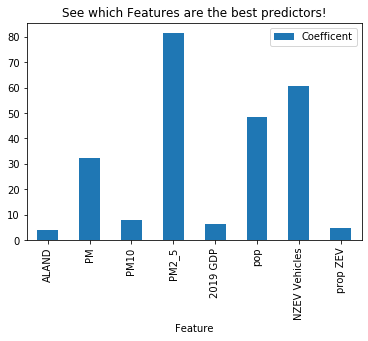

In [21]:
#Ridge
print("optimal alpha:", alpha_opt)
print("Test MSE with cross-validated Ridge:", ridgecv_mse)
print('R^2: ', r2_score(y_test, y_pred_ridgecv))

col_coef_zipped = zip(X.columns, ridge_cv_both[1])
col_coef = dict(col_coef_zipped)
feature_coef =pd.DataFrame(col_coef.items()).rename(columns ={0:'Feature', 1: 'Coefficent'})
feature_coef['Coefficent'] = np.abs(feature_coef['Coefficent'])

feature_coef.plot.bar(x= 'Feature', y= 'Coefficent')
plt.title('See which Features are the best predictors!')


Train Score:  0.9999998773643795
Validation Score:  0.870022341378065
Test Score:  0.3437135980722128


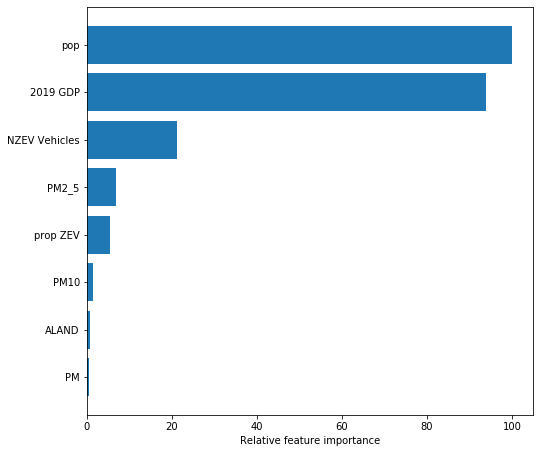

In [22]:
#GradientBootstingRegressor
gb_tree = GradientBoostingRegressor(n_estimators=162, max_features=7,random_state=2020)
gb_tree.fit(X_train, y_train)

gb_train_score = gb_tree.score(X_train, y_train)
gb_val_score = gb_tree.score(X_val, y_val)

print('Train Score: ', gb_train_score)
print('Validation Score: ', gb_val_score)
print('Test Score: ', gb_tree.score(X_test, y_test))

importance_plot(gb_tree)

**References**: <br>
GDP for Each CA County: https://www.bea.gov/data/gdp/gdp-county-metro-and-other-areas <br>
Population for Each CA County in 2019: https://www.california-demographics.com/counties_by_population<br>
ZEV& NZEV for Each CA county:https://tableau.cnra.ca.gov/t/CNRA_CEC/views/DMVDataPortal_15986380698710/STOCK_Dashboard?:showAppBanner=false&:display_count=n&:showVizHome=n&:origin=viz_share_link&:isGuestRedirectFromVizportal=y&:embed=y